# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import time
import seaborn as sns

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# MNIST Dataset

The MNIST dataset is automatically downloaded on first use by pytorch. To use it we need to convert the images to tensors using `torchvision.transforms.ToTensor()`

In [2]:
transform = transforms.ToTensor()

## Loading the data

Loading training data

In [3]:
train_data = datasets.MNIST(root='../Data', train=True, download=True, transform=transform)
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

Load test data

In [4]:
test_data = datasets.MNIST(root='../Data', train=False, download=True, transform=transform)
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

## Exploring the data

In [5]:
type(train_data)

torchvision.datasets.mnist.MNIST

In [6]:
type(train_data[0])

tuple

In [7]:
image,label = train_data[0]

The tuple is composed by the image with three channels. Given that it is a greyscale image the RGB channel is 1.

In [8]:
image.shape

torch.Size([1, 28, 28])

In [9]:
label

5

Using `plt` we can visualise the image in the default colourscale. Given that it has a single colour channel we can drop it.

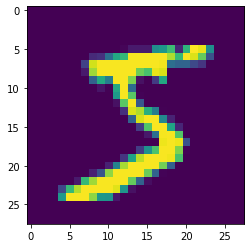

In [10]:
plt.imshow(image.reshape((28,28)))

Change colour mapping to be greyscale and greyscale inverted

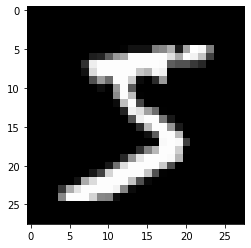

In [11]:
plt.imshow(image.reshape((28,28)),cmap='gray')

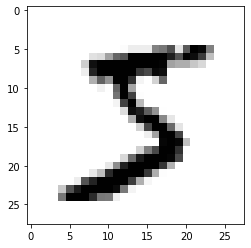

In [12]:
plt.imshow(image.reshape((28,28)),cmap='gist_yarg')

# Batch loading with DataLoader

The total number of parameters is:

- 748 incoming features 
- 120 and 84 neuron hidden layers
- 10 output features

$(784 \times 120) + 120 + (120 \times 84) + 84 + (84 \times 10) + 10 = 105,215$

Given the number of parameters, it makes sense to load the training data in batches using `DataLoader`

In [13]:
torch.manual_seed(101)

train_loader = DataLoader(train_data, batch_size=100, shuffle=True)

test_loader = DataLoader(test_data, batch_size=500, shuffle=False)

## Visualising a batch

In [14]:
from torchvision.utils import make_grid

Load the first batch into `images` and `labels`

In [15]:
for images,labels in train_loader:
    break

Labels:  [7 2 3 5 8 5 3 6 9 9 1 3]


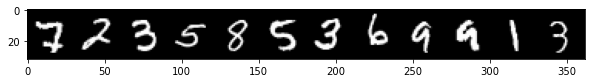

In [16]:
# Print the first 12 labels
print('Labels: ', labels[:12].numpy())

# Print the first 12 images
im = make_grid(images[:12], nrow=12)  # the default nrow is 8
plt.figure(figsize=(10,4))
# We need to transpose the images from CWH to WHC
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

# Define the model

In [17]:
'''class MultilayerPerceptron(nn.Module):
    def __init__(self, in_sz=784, out_sz=10, layers=[120,84]):
        super().__init__()
        self.fc1 = nn.Linear(in_sz,layers[0])
        self.fc2 = nn.Linear(layers[0],layers[1])
        self.fc3 = nn.Linear(layers[1],out_sz)
    
    def forward(self,X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)'''

'class MultilayerPerceptron(nn.Module):\n    def __init__(self, in_sz=784, out_sz=10, layers=[120,84]):\n        super().__init__()\n        self.fc1 = nn.Linear(in_sz,layers[0])\n        self.fc2 = nn.Linear(layers[0],layers[1])\n        self.fc3 = nn.Linear(layers[1],out_sz)\n    \n    def forward(self,X):\n        X = F.relu(self.fc1(X))\n        X = F.relu(self.fc2(X))\n        X = self.fc3(X)\n        return F.log_softmax(X, dim=1)'

In [18]:
'''torch.manual_seed(101)
model = MultilayerPerceptron()
model'''

'torch.manual_seed(101)\nmodel = MultilayerPerceptron()\nmodel'

In [19]:
class MultilayerPerceptron(nn.Module):
    
    def __init__(self, in_sz=784, out_sz=10, layers=[120,84]):

        super().__init__()
        
        layer_list = []
        for l in layers:
            layer_list.append(nn.Linear(in_sz,l))
            layer_list.append(nn.ReLU(inplace=True))
            in_sz = l
        
        layer_list.append(nn.Linear(layers[-1],out_sz))
        layer_list.append(nn.LogSoftmax(dim=1))
    
        
        self.layers = nn.Sequential(*layer_list)
        
    def forward(self,X):
    
        return self.layers(X)         

In [20]:
torch.manual_seed(101)
model = MultilayerPerceptron()
model

MultilayerPerceptron(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=120, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=84, out_features=10, bias=True)
    (5): LogSoftmax(dim=1)
  )
)

With an input size of 784 features, two hidden layers of 120 and 84 neurons, and an output layer with 10 neurons, the model has 105,214 parameters.

In [21]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters()]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [22]:
count_parameters(model)

 94080
   120
 10080
    84
   840
    10
______
105214


## Define loss function and optimiser

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Flattening the data

The model will be expeciting rows with 784 inputs. We will need to flatten the data. Current shape of a batch is 100 images, one colour channel, and a matrix of 28 by 28. We will need 100 images by 784 parameters.

`[100,1,28,28] --> [100,784]`

We can use the `.view()` function.

In [24]:
# Current shape
images.shape

torch.Size([100, 1, 28, 28])

In [25]:
images.view(100,-1).shape

torch.Size([100, 784])

## Model training

### Custom model

In [26]:
start_time = time.time()

epochs = 10
train_losses = []
train_correct = []
train_total = []

for i in range(epochs):
    trn_corr = 0
    trn_tot = 0
    i+=1
    
    for X_train,y_train in train_loader:
        # Batch size
        b_sz = X_train.shape[0]
        
        # Predict result
        y_pred = model(X_train.view(b_sz,-1))
        # Calculate the loss
        loss = criterion(y_pred, y_train)
        
        # Count correct predictions
        predicted = torch.max(y_pred,1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        trn_tot += b_sz
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Update train loss and accuracy for epoch
    train_losses.append(loss)
    train_correct.append(trn_corr)
    train_total.append(trn_tot)
    print(f'epoch: {i:3}  loss:{loss.item():10.6f}    accuracy:{(trn_corr/trn_tot)*100:7.3f}%')


total_time = time.time() - start_time
print(f'Duration:{total_time/60:.2f} min')

epoch:   1  loss:  0.137658    accuracy: 89.582%
epoch:   2  loss:  0.132700    accuracy: 95.347%
epoch:   3  loss:  0.046429    accuracy: 96.722%
epoch:   4  loss:  0.027433    accuracy: 97.500%
epoch:   5  loss:  0.078452    accuracy: 98.025%
epoch:   6  loss:  0.024285    accuracy: 98.403%
epoch:   7  loss:  0.034916    accuracy: 98.697%
epoch:   8  loss:  0.027247    accuracy: 98.902%
epoch:   9  loss:  0.042940    accuracy: 99.147%
epoch:  10  loss:  0.046022    accuracy: 99.267%
Duration:0.89 min


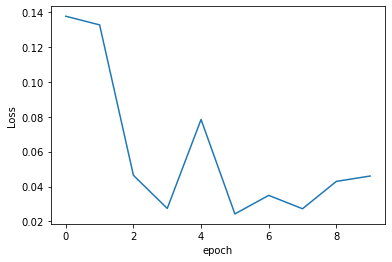

In [27]:
plt.plot(range(epochs), [l.item() for l in train_losses])
plt.ylabel('Loss')
plt.xlabel('epoch');

### Original model

In [28]:
'''start_time = time.time()

epochs = 10
train_losses = []
train_correct = []
train_total = []

for i in range(epochs):
    trn_corr = 0
    trn_tot = 0
    i+=1
    
    for X_train,y_train in train_loader:
        b_sz = X_train.shape[0]
        
        # Predict result
        y_pred = model(X_train.view(100,-1))
        # Calculate the loss
        loss = criterion(y_pred, y_train)
        
        # Count correct predictions
        predicted = torch.max(y_pred,1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        trn_tot += b_sz
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Update train loss and accuracy for epoch
    train_losses.append(loss)
    train_correct.append(trn_corr)
    train_total.append(trn_tot)
    print(f'epoch: {i:3}  loss:{loss.item():10.6f}    accuracy:{(trn_corr/trn_tot)*100:7.3f}%')


total_time = time.time() - start_time
print(f'Duration:{total_time/60:.2f} min')'''

"start_time = time.time()\n\nepochs = 10\ntrain_losses = []\ntrain_correct = []\ntrain_total = []\n\nfor i in range(epochs):\n    trn_corr = 0\n    trn_tot = 0\n    i+=1\n    \n    for X_train,y_train in train_loader:\n        b_sz = X_train.shape[0]\n        \n        # Predict result\n        y_pred = model(X_train.view(100,-1))\n        # Calculate the loss\n        loss = criterion(y_pred, y_train)\n        \n        # Count correct predictions\n        predicted = torch.max(y_pred,1)[1]\n        batch_corr = (predicted == y_train).sum()\n        trn_corr += batch_corr\n        trn_tot += b_sz\n        \n        # Update parameters\n        optimizer.zero_grad()\n        loss.backward()\n        optimizer.step()\n    \n    # Update train loss and accuracy for epoch\n    train_losses.append(loss)\n    train_correct.append(trn_corr)\n    train_total.append(trn_tot)\n    print(f'epoch: {i:3}  loss:{loss.item():10.6f}    accuracy:{(trn_corr/trn_tot)*100:7.3f}%')\n\n\ntotal_time = time.

In [29]:
'''plt.plot(range(epochs), [l.item() for l in train_losses])
plt.ylabel('Loss')
plt.xlabel('epoch');'''

"plt.plot(range(epochs), [l.item() for l in train_losses])\nplt.ylabel('Loss')\nplt.xlabel('epoch');"

## Model testing

In [30]:
tst_corr = 0
tst_tot = 0

pred_total = []
y_test_total = []

with torch.no_grad():
    
    for X_test, y_test in test_loader:
        # Batch size
        b_sz = X_test.shape[0]
        
        # Predict the result
        y_pred = model(X_test.view(b_sz,-1))
        # Calculate the loss
        loss = criterion(y_pred, y_test)
        
        # Count the correct predictions
        predicted = torch.max(y_pred,1)[1]
        batch_corr = (predicted==y_test).sum()
        tst_corr += batch_corr
        tst_tot += b_sz
        
        pred_total.append(predicted)
        y_test_total.append(y_test)
    
    print(f'loss:{loss.item():10.6f}    accuracy:{(tst_corr/tst_tot)*100:7.3f}%')

loss:  0.133621    accuracy: 97.850%


In [31]:
y_test_total = torch.concat(y_test_total)
pred_total = torch.concat(pred_total)
cm = confusion_matrix(y_test_total, pred_total)

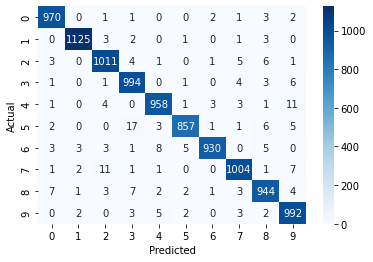

In [32]:
cm_plot = sns.heatmap(cm,annot=True, cmap='Blues',fmt='g')
cm_plot.set(xlabel='Predicted',ylabel='Actual');

# Examine Misses

In [33]:
# Get missed items indexes
misses_idx = np.where(pred_total.numpy()!=y_test_total.numpy())[0]
# Split in batches
misses_idx.shape

(215,)

In [34]:
# Setup iterator
row = iter(np.array_split(misses_idx, len(misses_idx)//10))

Index: [1609 1681 1717 1751 1754 1790 1800 1878 1901 1987 2004]
Label: [2 3 8 4 7 2 6 8 9 0 8]
Guess: [6 7 0 7 2 8 4 3 4 9 9]


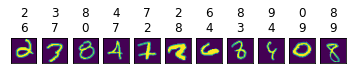

In [39]:
nextrow = next(row)
lab = y_test_total.index_select(0,torch.tensor(nextrow)).numpy()
gs = pred_total.index_select(0,torch.tensor(nextrow)).numpy()
print("Index:", nextrow)
print("Label:", lab)
print("Guess:", gs)

images = test_data.data[nextrow]
#im = make_grid(images, nrow=11)
fix, axs = plt.subplots(nrows=1, ncols=len(nextrow))
for ax, im, l, g in zip(axs,images, lab, gs):
    ax.imshow(im)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'{l}\n{g}')